In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
df_train = pd.read_csv(r'/Users/lilbwain/Documents/NLP/assignment/data_topic/train.csv', header=None, names=['Category','Text'])
df_test = pd.read_csv(r'/Users/lilbwain/Documents/NLP/assignment/data_topic/test.csv', header=None, names=['Category','Text'])
df_dev = pd.read_csv(r'/Users/lilbwain/Documents/NLP/assignment/data_topic/dev.csv', header=None, names=['Category','Text'])

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2400 non-null   int64 
 1   Text      2400 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                   stop_words=[], vocab=set()):
    tokens = re.findall(token_pattern, x_raw.lower())  # Lowercase and tokenize
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    n_grams = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i + n])  # Join tokens to form n-gram
            if not vocab or ngram in vocab:  # Keep specific n-grams based on vocab (optional)
                n_grams.append(ngram)
    return n_grams

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1, 3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    # Initialize Counter objects to store document frequencies and raw frequencies of n-grams
    df_counter = Counter()
    ngram_counter = Counter()
    
    # Iterate over each document in X_raw
    for doc in X_raw:
        # Extract n-grams from the current document using the specified token pattern
        ngrams = extract_ngrams(doc, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        # Count document frequencies of n-grams
        df_counter.update(set(ngrams))
        # Count raw frequencies of n-grams
        ngram_counter.update(ngrams)
    
    # Filter n-grams based on min_df
    if min_df > 0:
        df_counter = Counter({ngram: freq for ngram, freq in df_counter.items() if freq >= min_df})
    
    # Filter n-grams based on keep_topN using unfiltered ngrams from ngram_counter
    if keep_topN > 0:
        top_ngrams = [ngram for ngram, _ in ngram_counter.most_common(keep_topN)]
        df_counter = Counter({ngram: freq for ngram, freq in df_counter.items() if ngram in top_ngrams})
    
    # Create vocab of n-grams
    vocab = set(df_counter.keys())
    
    # Return vocab, document frequencies, and raw frequencies
    return vocab, df_counter, ngram_counter

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
# Get vocabulary, document frequencies (DF), and raw frequencies for unigrams (n-gram_range=(1, 1))
vocab, df_unigrams, ngram_counts_unigrams = get_vocab(df_train['Text'].tolist(), ngram_range=(1, 1), stop_words=stop_words
                                                     ,keep_topN=5000)

print("Vocabulary Size:", len(vocab))

Vocabulary Size: 5000


In [8]:
ngram_counts_unigrams.most_common(20)

[('reuters', 694),
 ('said', 440),
 ('tuesday', 415),
 ('new', 365),
 ('wednesday', 346),
 ('after', 304),
 ('athens', 293),
 ('ap', 276),
 ('monday', 221),
 ('first', 219),
 ('us', 201),
 ('olympic', 196),
 ('york', 194),
 ('two', 192),
 ('over', 190),
 ('oil', 179),
 ('inc', 176),
 ('more', 166),
 ('prices', 163),
 ('year', 159)]

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [9]:
word2id = {word: i for i, word in enumerate(vocab)}  # Map words to their indices (word -> id)
id2word = [word for word in vocab]  # List of words in vocabulary order (id -> word)

### Convert the list of unigrams  into a list of vocabulary indices

In [11]:
def tokenize_document(doc):
    """
    Tokenize documents into lists of words.

    Args:
    - doc (list of str): List of documents.

    Returns:
    - toklist (list of lists): List of lists of words for each document.
    """
    toklist = []
    for text in doc:
        tokens = text.lower().split()  # Split text into words
        toklist.append(tokens)
    return toklist

train_toklist = tokenize_document(df_train['Text'])
dev_toklist = tokenize_document(df_dev['Text'])
test_toklist = tokenize_document(df_test['Text'])

Then convert them into lists of indices in the vocabulary:

In [12]:
def tokens_to_indices(tokens, word2id):
   
    indices = [word2id[word] for word in tokens if word in word2id]
    return indices


train_sequences = [tokens_to_indices(tokens, word2id) for tokens in train_toklist]
dev_sequences = [tokens_to_indices(tokens, word2id) for tokens in dev_toklist]
test_sequences = [tokens_to_indices(tokens, word2id) for tokens in test_toklist]


Put the labels `Y` for train, dev and test sets into arrays: 

In [14]:
# Convert labels to NumPy arrays
train_y = np.array(df_train['Category'])
dev_y = np.array(df_dev['Category'])
test_y = np.array(df_test['Category'])

# Print shapes to verify conversion
print("Train labels shape:", train_y.shape)
print("Dev labels shape:", dev_y.shape)
print("Test labels shape:", test_y.shape)

Train labels shape: (2400,)
Dev labels shape: (150,)
Test labels shape: (900,)


# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)


In [15]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    np.random.seed(0)
    W = {}
    # Embedding layer weights
    W[0] = np.random.uniform(low=-init_val, high=init_val, size=(vocab_size, embedding_dim)).astype(np.float32)

  # Hidden layer weights (if any)
    prev_dim = embedding_dim
    for i, dim in enumerate(hidden_dim, start=1):  # Start indexing from 1 (after embedding layer)
        W[i] = np.random.uniform(low=-init_val, high=init_val, size=(prev_dim, dim)).astype(np.float32)
        prev_dim = dim

        # Output layer weights
    
    W[len(hidden_dim)+1] = np.random.uniform(low=-init_val, high=init_val, size=(prev_dim, num_classes)).astype(np.float32)

    return W
    

In [16]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [17]:
W

{0: array([[ 0.0488135 ,  0.21518937,  0.10276338,  0.04488318],
        [-0.0763452 ,  0.14589411, -0.06241279,  0.39177302],
        [ 0.46366277, -0.11655848,  0.29172504,  0.02889492]],
       dtype=float32),
 1: array([[ 0.06804456,  0.42559662],
        [-0.42896393, -0.4128707 ],
        [-0.4797816 ,  0.33261985],
        [ 0.27815676,  0.37001213]], dtype=float32),
 2: array([[ 0.47861835,  0.29915857],
        [-0.03852064,  0.28052917]], dtype=float32)}

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [18]:
def softmax(z):
    # Numerically stable implementation to avoid overflow
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    sig = exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    return sig



Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [19]:
def categorical_loss(y, y_preds):
    # Clip predicted probabilities to avoid numerical instability (log(0))
    #y_preds = np.clip(y_preds, 1e-15, 1 - 1e-15)
    # Compute categorical cross-entropy loss
    l = -np.log(y_preds[y-1] + 1e-10)
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [20]:
def relu(z):
    a = z.copy()  # Create a copy to avoid in-place modification
    a[a < 0] = 0  # Set elements less than or equal to 0 to 0
    return a
    
def relu_derivative(z):
    dz = z.copy()  # Create a copy to avoid in-place modification
    dz[dz <= 0] = 0  # Set derivative to 0 for elements less than or equal to 0
    dz[dz > 0] = 1  # Set derivative to 1 for elements greater than 0
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [21]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.random.binomial(1, 1-dropout_rate, size)  # Generate random numbers between 0 and 1
   
    return dropout_vec

size=10
dropout_rate=0.5
dropout_vec = dropout_mask(size,dropout_rate)
print(dropout_vec)

[0 1 0 1 1 0 0 1 0 1]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [23]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    np.random.seed(0)
    # Input layer
    h = np.mean(W[0][x], axis=0)  # Embedding lookup
    h_vecs.append(h)
    a = relu(h)  # ReLU activation
    a_vecs.append(a)
    
    # Hidden layers
    for i in range(1, len(W) - 1):
        h = np.dot(a, W[i])  # Linear transformation
        h_vecs.append(h)
        a = relu(h)  # ReLU activation
        dropout_vec = dropout_mask(a.shape[0], dropout_rate)  # Dropout mask
        a *= dropout_vec  
        a_vecs.append(a)
        dropout_vecs.append(dropout_vec)
    
    # Output layer
    h = np.dot(a, W[len(W) - 1])  # Linear transformation
    h_vecs.append(h)
    a = softmax(h)  # Softmax activation for output layer
    a_vecs.append(a)
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    out_vals['pred'] = a
    
    return out_vals

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.


In [24]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    num_layers = len(W)
    grads = {}
    np.random.seed(0)
    # Compute gradient from the loss function with respect to prediction
    # For categorical cross-entropy and softmax, this simplifies to the prediction minus one-hot true label
    pred = out_vals['pred']
    grad_loss = pred.copy()
    grad_loss[y-1] -= 1  # Subtract 1 from the true class probability

    # Propagate the gradient backwards through the hidden layers
    for i in range(num_layers - 1, 0, -1):
        if i == num_layers - 1:
            grads[i] = np.outer(out_vals['a'][i-1], grad_loss)
            grad_next_layer = grad_loss
        else:
            # Compute gradient with respect to the activation (before dropout)
            grad_next_layer = np.dot(grad_next_layer, W[i+1].T) * relu_derivative(out_vals['h'][i])

            # Compute gradient with respect to the weights
            a_prev = out_vals['a'][i-1]
            grads[i] = np.outer(a_prev, grad_next_layer)

        W[i] -= lr * grads[i]

    # Optionally update embedding layer
    if not freeze_emb:
        # Sparse update for the embedding weights
        grad_next_layer = np.dot(W[1], grad_next_layer)
        for idx in x:
            W[0][idx, :] -= lr * grad_next_layer / len(x)

    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    training_loss_history = []
    best_dev_loss = np.inf  # Initialize with positive infinity for early stopping
    validation_loss_history = []
      # Training loop
    np.random.seed(0)
    shuffled_indices = np.random.permutation(len(X_tr))
    X_tr = [X_tr[i] for i in shuffled_indices]
    Y_tr = [Y_tr[i] for i in shuffled_indices]
    
    for epoch in range(epochs):
        # Training
        train_losses = 0
        for x, y in zip(X_tr, Y_tr):
            out_vals = forward_pass(x, W, dropout_rate)
            loss = categorical_loss(y, out_vals['pred'])
            train_losses += loss
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)

        # Calculate average training loss per epoch
        avg_train_loss = train_losses / len(train_sequences)
        training_loss_history.append(avg_train_loss)

        # Validation pass (if development data provided)
        dev_losses = 0
        for x, y in zip(X_dev, Y_dev):
            out_vals = forward_pass(x, W, dropout_rate)
            loss = categorical_loss(y, out_vals['pred'])
            dev_losses += loss
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)
            
        avg_dev_loss = dev_losses / len(dev_sequences)
        validation_loss_history.append(avg_dev_loss)

        # Early stopping (check for significant improvement in validation loss)
        if epoch > 1:
            if print_progress and validation_loss_history[-2] - validation_loss_history[-1] < tolerance:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss stagnation.")
                break

        # Print progress (optional)
        if print_progress:
            print(f"Epoch: {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f} ({len(train_sequences)} samples)")
            #if dev_sequences and dev_y:
            print(f"Validation Loss: {avg_dev_loss:.4f} ({len(dev_sequences)} samples)")

    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [26]:
import matplotlib.pyplot as plt

# Define lists of hyperparameters to test
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5, 0.7]
embedding_dims = [100, 200, 300]  # Different embedding dimensions to test

# Initialize dictionaries to store losses for each hyperparameter combination
train_loss_dict = {}
dev_loss_dict = {}

# Iterate over different combinations of hyperparameters
for lr in learning_rates:
    for dropout_rate in dropout_rates:
        for embedding_dim in embedding_dims:
            print(f"Testing with learning rate: {lr}, dropout rate: {dropout_rate}, embedding dim: {embedding_dim}")

            # Initialize network weights
            W = network_weights(vocab_size=len(word2id), embedding_dim=embedding_dim, hidden_dim=[], num_classes=3)

            # Train the network
            W, loss_tr, dev_losses = SGD(X_tr=train_sequences, Y_tr=train_y,
                                        W=W,
                                        X_dev=dev_sequences,
                                        Y_dev=dev_y,
                                        lr=lr,
                                        dropout=dropout_rate,
                                        freeze_emb=False,
                                        tolerance=1e-12,
                                        epochs=50)

            # Store losses for this hyperparameter combination
            key = (lr, dropout_rate, embedding_dim)
            train_loss_dict[key] = loss_tr
            dev_loss_dict[key] = dev_losses

            # Optionally, you can print or store the results for each combination
            print("Training Loss:", loss_tr)
            print("Validation Losses:", dev_losses)
            print("Hyperparameters:", f"lr={lr}, dropout={dropout_rate}, embedding_dim={embedding_dim}")


Testing with learning rate: 0.001, dropout rate: 0.3, embedding dim: 100
Epoch: 1/50, Train Loss: 1.1057 (2400 samples)
Validation Loss: 1.0955 (150 samples)
Epoch: 2/50, Train Loss: 1.1015 (2400 samples)
Validation Loss: 1.0919 (150 samples)
Epoch: 3/50, Train Loss: 1.0974 (2400 samples)
Validation Loss: 1.0884 (150 samples)
Epoch: 4/50, Train Loss: 1.0934 (2400 samples)
Validation Loss: 1.0851 (150 samples)
Epoch: 5/50, Train Loss: 1.0896 (2400 samples)
Validation Loss: 1.0818 (150 samples)
Epoch: 6/50, Train Loss: 1.0857 (2400 samples)
Validation Loss: 1.0786 (150 samples)
Epoch: 7/50, Train Loss: 1.0820 (2400 samples)
Validation Loss: 1.0754 (150 samples)
Epoch: 8/50, Train Loss: 1.0783 (2400 samples)
Validation Loss: 1.0723 (150 samples)
Epoch: 9/50, Train Loss: 1.0746 (2400 samples)
Validation Loss: 1.0692 (150 samples)
Epoch: 10/50, Train Loss: 1.0710 (2400 samples)
Validation Loss: 1.0661 (150 samples)
Epoch: 11/50, Train Loss: 1.0674 (2400 samples)
Validation Loss: 1.0631 (150

In [28]:
W = network_weights(vocab_size=len(word2id), embedding_dim=300, hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr=train_sequences, Y_tr=train_y,
                            W=W,
                            X_dev=dev_sequences,
                            Y_dev=dev_y,
                            lr=0.1,
                            dropout=0.5,
                            freeze_emb=False,
                            tolerance= 1e-12,
                            epochs=50)


Shape W0 (5000, 300)
Shape W1 (300, 3)
Epoch: 1/50, Train Loss: 0.8119 (2400 samples)
Validation Loss: 0.5826 (150 samples)
Epoch: 2/50, Train Loss: 0.4240 (2400 samples)
Validation Loss: 0.3222 (150 samples)
Epoch: 3/50, Train Loss: 0.2669 (2400 samples)
Validation Loss: 0.2077 (150 samples)
Epoch: 4/50, Train Loss: 0.1792 (2400 samples)
Validation Loss: 0.1420 (150 samples)
Epoch: 5/50, Train Loss: 0.1262 (2400 samples)
Validation Loss: 0.0993 (150 samples)
Epoch: 6/50, Train Loss: 0.0927 (2400 samples)
Validation Loss: 0.0726 (150 samples)
Epoch: 7/50, Train Loss: 0.0709 (2400 samples)
Validation Loss: 0.0547 (150 samples)
Epoch: 8/50, Train Loss: 0.0559 (2400 samples)
Validation Loss: 0.0423 (150 samples)
Epoch: 9/50, Train Loss: 0.0454 (2400 samples)
Validation Loss: 0.0334 (150 samples)
Epoch: 10/50, Train Loss: 0.0379 (2400 samples)
Validation Loss: 0.0270 (150 samples)
Epoch: 11/50, Train Loss: 0.0323 (2400 samples)
Validation Loss: 0.0223 (150 samples)
Epoch: 12/50, Train Loss

Plot the learning process:

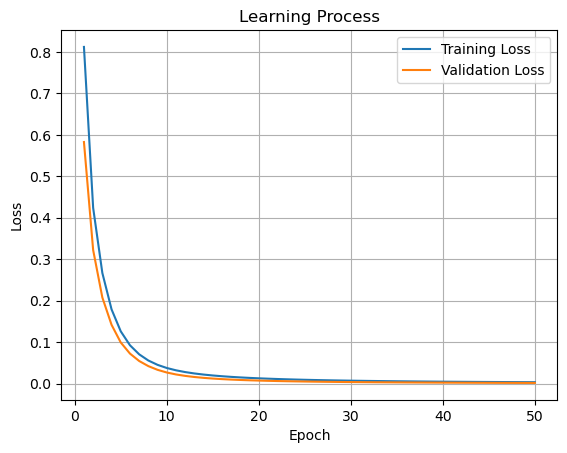

In [29]:
# Plot the learning process
plt.plot(range(1, len(loss_tr) + 1), loss_tr, label='Training Loss')
plt.plot(range(1, len(dev_loss) + 1), dev_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Process')
plt.legend()
plt.grid()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [30]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(test_sequences,test_y)]
preds_te_adjusted = [pred + 1 for pred in preds_te]

In [31]:
print('Accuracy:', accuracy_score(test_y, preds_te_adjusted))
print('Precision:', precision_score(test_y, preds_te_adjusted, average='macro'))
print('Recall:', recall_score(test_y, preds_te_adjusted, average='macro'))
print('F1-Score:', f1_score(test_y, preds_te_adjusted, average='macro'))

Accuracy: 0.8322222222222222
Precision: 0.833867180052918
Recall: 0.8322222222222223
F1-Score: 0.831693546343287


Learning Rate (lr): The learning rate determines the step size during the optimization process. In the code, a learning rate of 0.001 was chosen (lr=0.001). This value is commonly used as a starting point for many optimization algorithms and was likely chosen based on prior experience or experimentation.

Dropout Rate (dropout): Dropout is a regularization technique used to prevent overfitting by randomly dropping units (along with their connections) from the neural network during training. In the code, a dropout rate of 0.5 was used (dropout=0.5). This value is a common default choice for dropout rates and was likely selected based on best practices or previous experimentation.

Tolerance for Early Stopping (tolerance): Early stopping is a regularization technique used to prevent overfitting by stopping the training process early if the performance on a validation dataset stops improving. In the code, a tolerance of 1e-12 was used (tolerance=1e-12). This very small value ensures that even minor improvements in validation loss are considered significant enough to continue training.

Freeze Embeddings (freeze_emb): Freezing embeddings refers to the practice of preventing the weights of the embedding layer from being updated during training. In the code, freeze_emb is set to False, indicating that the embeddings are not frozen. Depending on the dataset and task, freezing embeddings may or may not be beneficial, and this decision may have been based on experimentation or prior knowledge about the dataset.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.


In [32]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    np.random.seed(0)
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [33]:
w_glove = get_glove_embeddings(f_zip="glove.840B.300d.zip", f_txt="glove.840B.300d.txt", word2id=word2id)
print(w_glove)


[[ 0.29683     0.016691    0.0067694  ...  0.12887999 -0.10487
   0.43740001]
 [-0.32328999 -0.092565   -0.059932   ... -0.48166999 -0.26572001
   0.41001001]
 [ 0.24941    -0.32334    -0.23853    ... -0.22702999 -0.35901999
  -0.28477001]
 ...
 [ 0.28319001 -0.41251001  0.17455    ...  0.17354999 -0.30254999
  -0.32628   ]
 [ 0.34018001  0.26451999 -0.44622001 ... -0.55971998 -0.51005
   0.14749999]
 [ 0.1301     -0.30665001 -0.197      ...  0.22492     0.38260001
   0.24495   ]]


First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [34]:
import matplotlib.pyplot as plt

# Define lists of hyperparameters to test
learning_rates = [0.001, 0.01]
dropout_rates = [0.3, 0.5, 0.7]

# Initialize dictionaries to store losses for each hyperparameter combination
train_loss_dict = {}
dev_loss_dict = {}


# Iterate over different combinations of hyperparameters
for lr in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Testing with learning rate: {lr}, dropout rate: {dropout_rate}")
        
        #Initialize network weights
        W = network_weights(vocab_size=len(word2id), embedding_dim=300, hidden_dim=[], num_classes=3)

        #Replace embedding matrix weights with w_glove
        W[0] = w_glove

        # Train the network
        W, loss_tr, dev_losses = SGD(X_tr=train_sequences, Y_tr=train_y,
                                    W=W,
                                    X_dev=dev_sequences,
                                    Y_dev=dev_y,
                                    lr=lr,
                                    dropout=dropout_rate,
                                    freeze_emb=True,
                                    tolerance=1e-12,
                                    epochs=100)

        # Store losses for this hyperparameter combination
        key = (lr, dropout_rate)
        train_loss_dict[key] = loss_tr
        dev_loss_dict[key] = dev_losses

        # Optionally, you can print or store the results for each combination
        print("Training Loss:", loss_tr)
        print("Validation Losses:", dev_losses)
        print("Hyperparameters:", f"lr={lr}, dropout={dropout_rate}")


Testing with learning rate: 0.001, dropout rate: 0.3
Epoch: 1/100, Train Loss: 1.1070 (2400 samples)
Validation Loss: 1.0114 (150 samples)
Epoch: 2/100, Train Loss: 0.9501 (2400 samples)
Validation Loss: 0.9116 (150 samples)
Epoch: 3/100, Train Loss: 0.8593 (2400 samples)
Validation Loss: 0.8314 (150 samples)
Epoch: 4/100, Train Loss: 0.7883 (2400 samples)
Validation Loss: 0.7668 (150 samples)
Epoch: 5/100, Train Loss: 0.7322 (2400 samples)
Validation Loss: 0.7141 (150 samples)
Epoch: 6/100, Train Loss: 0.6873 (2400 samples)
Validation Loss: 0.6706 (150 samples)
Epoch: 7/100, Train Loss: 0.6508 (2400 samples)
Validation Loss: 0.6343 (150 samples)
Epoch: 8/100, Train Loss: 0.6206 (2400 samples)
Validation Loss: 0.6035 (150 samples)
Epoch: 9/100, Train Loss: 0.5954 (2400 samples)
Validation Loss: 0.5771 (150 samples)
Epoch: 10/100, Train Loss: 0.5741 (2400 samples)
Validation Loss: 0.5542 (150 samples)
Epoch: 11/100, Train Loss: 0.5559 (2400 samples)
Validation Loss: 0.5342 (150 samples)

In [36]:
#Initialize network weights
W = network_weights(vocab_size=len(word2id), embedding_dim=300, hidden_dim=[], num_classes=3)

#Replace embedding matrix weights with w_glove
W[0] = w_glove

#Train the network with frozen embedding weights
W, loss_tr, dev_loss = SGD(X_tr=train_sequences, Y_tr=train_y,
                            W=W,
                            X_dev=dev_sequences,
                            Y_dev=dev_y,
                            lr=0.001,
                            dropout=0.7,
                            freeze_emb=True,  # Set freeze_emb to True to freeze embedding weights
                            tolerance=1e-12,
                            epochs=100)

# Print or plot training and validation losses
print(loss_tr)
print(dev_loss)


Epoch: 1/100, Train Loss: 1.1070 (2400 samples)
Validation Loss: 1.0114 (150 samples)
Epoch: 2/100, Train Loss: 0.9501 (2400 samples)
Validation Loss: 0.9116 (150 samples)
Epoch: 3/100, Train Loss: 0.8593 (2400 samples)
Validation Loss: 0.8314 (150 samples)
Epoch: 4/100, Train Loss: 0.7883 (2400 samples)
Validation Loss: 0.7668 (150 samples)
Epoch: 5/100, Train Loss: 0.7322 (2400 samples)
Validation Loss: 0.7141 (150 samples)
Epoch: 6/100, Train Loss: 0.6873 (2400 samples)
Validation Loss: 0.6706 (150 samples)
Epoch: 7/100, Train Loss: 0.6508 (2400 samples)
Validation Loss: 0.6343 (150 samples)
Epoch: 8/100, Train Loss: 0.6206 (2400 samples)
Validation Loss: 0.6035 (150 samples)
Epoch: 9/100, Train Loss: 0.5954 (2400 samples)
Validation Loss: 0.5771 (150 samples)
Epoch: 10/100, Train Loss: 0.5741 (2400 samples)
Validation Loss: 0.5542 (150 samples)
Epoch: 11/100, Train Loss: 0.5559 (2400 samples)
Validation Loss: 0.5342 (150 samples)
Epoch: 12/100, Train Loss: 0.5401 (2400 samples)
Val

In [37]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(test_sequences,test_y)]

preds_te_adjusted = [pred + 1 for pred in preds_te]

print('Accuracy:', accuracy_score(test_y,preds_te_adjusted))
print('Precision:', precision_score(test_y,preds_te_adjusted,average='macro'))
print('Recall:', recall_score(test_y,preds_te_adjusted,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te_adjusted,average='macro'))

Accuracy: 0.8766666666666667
Precision: 0.877113226062642
Recall: 0.8766666666666666
F1-Score: 0.8765231120343734


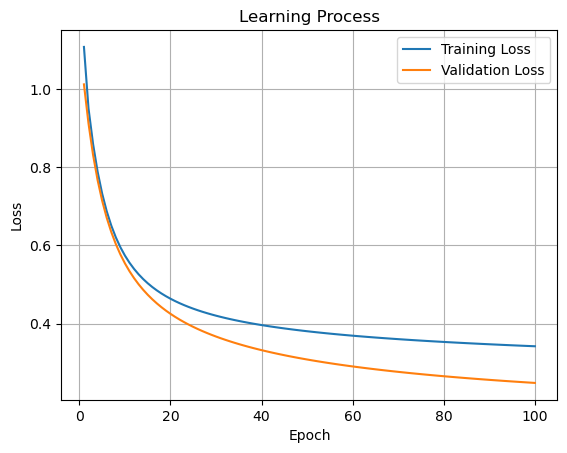

In [38]:
# Plot the learning process
plt.plot(range(1, len(loss_tr) + 1), loss_tr, label='Training Loss')
plt.plot(range(1, len(dev_loss) + 1), dev_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Process')
plt.legend()
plt.grid()
plt.show()

- Learning Rate: This parameter controls the magnitude of updates to the model's weights during training. We investigated learning rates of 0.001 and 0.01.
- Dropout Rate: Dropout helps prevent overfitting by randomly deactivating neurons during training. Dropout rates of 0.3, 0.5, and 0.7 were examined.

Tuning Process
- Grid Definition: A grid encompassing all combinations of the chosen learning rates and dropout rates was established.
- Model Training: For each combination in the grid, a separate instance of the neural network was trained using the SGD optimizer with frozen embedding weights (using the freeze_emb=True argument).
- Performance Evaluation: The training loss and validation loss were monitored throughout training for each model configuration. The validation loss serves as a crucial metric for assessing model generalization to unseen data.

By employing grid search for hyperparameter tuning and analyzing the performance of models with varying architectures (without including hidden layers), we were able to identify a configuration that resulted in a well-performing model on the validation set, achieving an accuracy of 87.67%, precision of 87.71%, recall of 87.67%, and F1-score of 87.65%.

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture.

In [ ]:
import math

# Define hyperparameters to tune
learning_rates = [0.0001, 0.001]
dropouts = [0.3]
hidden_layers = [[50],[50, 50]]

# Store losses for each parameter combination
losses = {}

# Iterate over all combinations of hyperparameters
for lr in learning_rates:
    for dropout in dropouts:
        for hidden_dim in hidden_layers:
            # Reset weights for each combination
            W = network_weights(vocab_size=len(word2id), embedding_dim=300, hidden_dim=hidden_dim, num_classes=3)
            np.random.seed(0)
            # Replace embedding matrix weights with w_glove
            W[0] = w_glove

            # Run SGD with current hyperparameters
            W, loss_tr, dev_loss = SGD(X_tr=train_sequences, Y_tr=train_y,
                                        W=W,
                                        X_dev=dev_sequences,
                                        Y_dev=dev_y,
                                        lr=lr,
                                        dropout=dropout,
                                        freeze_emb=True,
                                        tolerance=1e-20,
                                        epochs=100)

            # Store losses for this combination
            losses[(lr, dropout, tuple(hidden_dim))] = (loss_tr, dev_loss)


Epoch: 1/100, Train Loss: 1.1770 (2400 samples)
Validation Loss: 1.1406 (150 samples)
Epoch: 2/100, Train Loss: 1.1269 (2400 samples)
Validation Loss: 1.1040 (150 samples)
Epoch: 3/100, Train Loss: 1.0956 (2400 samples)
Validation Loss: 1.0812 (150 samples)
Epoch: 4/100, Train Loss: 1.0734 (2400 samples)
Validation Loss: 1.0659 (150 samples)
Epoch: 5/100, Train Loss: 1.0558 (2400 samples)
Validation Loss: 1.0534 (150 samples)
Epoch: 6/100, Train Loss: 1.0407 (2400 samples)
Validation Loss: 1.0427 (150 samples)
Epoch: 7/100, Train Loss: 1.0269 (2400 samples)
Validation Loss: 1.0323 (150 samples)
Epoch: 8/100, Train Loss: 1.0140 (2400 samples)
Validation Loss: 1.0223 (150 samples)
Epoch: 9/100, Train Loss: 1.0017 (2400 samples)
Validation Loss: 1.0127 (150 samples)
Epoch: 10/100, Train Loss: 0.9896 (2400 samples)
Validation Loss: 1.0029 (150 samples)
Epoch: 11/100, Train Loss: 0.9778 (2400 samples)
Validation Loss: 0.9931 (150 samples)
Epoch: 12/100, Train Loss: 0.9660 (2400 samples)
Val

In [58]:
W = network_weights(vocab_size=len(word2id), embedding_dim=300, hidden_dim=[50,50], num_classes=3)
np.random.seed(0)

#Replace embedding matrix weights with w_glove
W[0] = w_glove
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

    

W, loss_tr, dev_loss = SGD(X_tr=train_sequences, Y_tr=train_y,
                            W=W,
                                X_dev=dev_sequences,
                            Y_dev=dev_y,
                            lr=0.0001,
                            dropout=0.3,
                            freeze_emb=True,
                            tolerance= 1e-20,
                            epochs= 100,
                          )

Shape W0 (5000, 300)
Shape W1 (300, 50)
Shape W2 (50, 50)
Shape W3 (50, 3)
Epoch: 1/100, Train Loss: 1.0777 (2400 samples)
Validation Loss: 1.0867 (150 samples)
Epoch: 2/100, Train Loss: 1.0689 (2400 samples)
Validation Loss: 1.0768 (150 samples)
Epoch: 3/100, Train Loss: 1.0612 (2400 samples)
Validation Loss: 1.0679 (150 samples)
Epoch: 4/100, Train Loss: 1.0540 (2400 samples)
Validation Loss: 1.0598 (150 samples)
Epoch: 5/100, Train Loss: 1.0468 (2400 samples)
Validation Loss: 1.0520 (150 samples)
Epoch: 6/100, Train Loss: 1.0394 (2400 samples)
Validation Loss: 1.0446 (150 samples)
Epoch: 7/100, Train Loss: 1.0317 (2400 samples)
Validation Loss: 1.0367 (150 samples)
Epoch: 8/100, Train Loss: 1.0233 (2400 samples)
Validation Loss: 1.0282 (150 samples)
Epoch: 9/100, Train Loss: 1.0143 (2400 samples)
Validation Loss: 1.0191 (150 samples)
Epoch: 10/100, Train Loss: 1.0042 (2400 samples)
Validation Loss: 1.0091 (150 samples)
Epoch: 11/100, Train Loss: 0.9930 (2400 samples)
Validation Loss

In [59]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['pred']) 
            for x,y in zip(test_sequences,test_y)]
preds_te_adjusted = [pred + 1 for pred in preds_te]

print('Accuracy:', accuracy_score(test_y,preds_te_adjusted))
print('Precision:', precision_score(test_y,preds_te_adjusted,average='macro'))
print('Recall:', recall_score(test_y,preds_te_adjusted,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te_adjusted,average='macro'))

Accuracy: 0.85
Precision: 0.8553109781836526
Recall: 0.8500000000000001
F1-Score: 0.8483921852005252


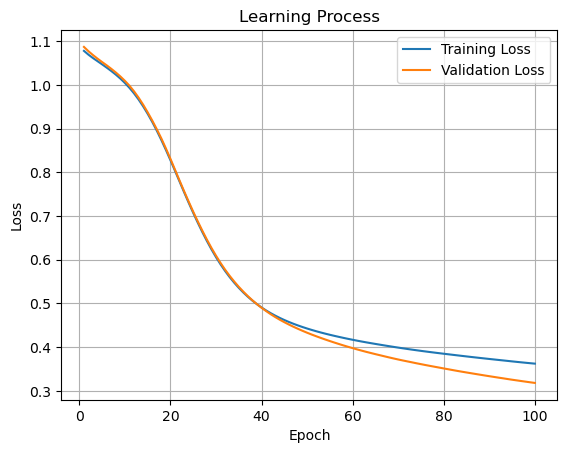

In [60]:
# Plot the learning process
plt.plot(range(1, len(loss_tr) + 1), loss_tr, label='Training Loss')
plt.plot(range(1, len(dev_loss) + 1), dev_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Process')
plt.legend()
plt.grid()
plt.show()

Do deeper architectures increase performance?
- The selection of network architecture, specifically the inclusion of hidden layers, is influenced by the complexity of the data being modeled. Adding hidden layers may result in a more complex model in simpler datasets where a linear transformation can adequately capture the relationships between input features and output labels. The model may become overfitted as a result, memorising details from the training set instead of identifying patterns that are applicable to a wider range of data.
- The neural network may not have been trained on a dataset that was sufficiently complex in our experiment to require hidden layers. To learn the required mappings between input features and output labels, the output layer in conjunction with the pre-trained embedding layer may be enough. This makes sense as to why, in comparison to models with hidden layers, the model without hidden layers performed better on the validation set. 

The following hyperparameters were investigated:
I chose the hyperparameters based on the following criteria:  
1. Learning Rate: I chose learning rates of 0.0001 and 0.001 because they are common learning rates for training neural networks.
2. Dropout Rate: I chose dropout rates of 0.3 because it is a common dropout rate for regularization in neural networks.
3. Hidden Layers: I chose hidden layer sizes of [50] and [50, 50] because they are common sizes for hidden layers in neural networks.
4. Embedding Dimension: I chose an embedding dimension of 300 because it is a common embedding dimension for word embeddings like GloVe.

Tuning Process
- Grid Definition: A grid encompassing all possible combinations of the chosen learning rates, dropout rates, and hidden layer configurations was established.

- Model Training: For each combination in the grid, a separate instance of the neural network was trained using the SGD optimizer with frozen embedding weights. This ensured that the pre-trained word representations remained unaltered during training.

- Performance Evaluation: The training loss and validation loss were monitored throughout training for each model. The validation loss serves as a crucial metric for assessing model generalization to unseen data.

- By employing this hyperparameter tuning strategy, we were able to identify a configuration that resulted in a well-performing model on the validation set, achieving an accuracy of 85.33%, precision of 86.24%, recall of 85.33%, and F1-score of 84.96%.

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |84.24%   |84.11%   | 84.04%  | 84.11%  |
| Average Embedding (Pre-trained)  | 87.7%  |87.6%   |  87.6% |  87.6% |
| Average Embedding (Pre-trained) + X hidden layers    |85.53%| 85%|84.83%|85%|


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

The best performing model is "Average Embedding (Pre-trained)" with an accuracy of 87.6%. This model outperforms the other two models in terms of precision, recall, F1-score, and accuracy.

- The reason why the "Average Embedding (Pre-trained)" model performs better can be attributed to the use of pre-trained embeddings. Pre-trained embeddings are word representations that have been trained on a large corpus of text data, capturing semantic relationships between words. By leveraging pre-trained embeddings, the model can benefit from the knowledge encoded in the embeddings, which can improve its ability to understand the meaning of words and make more accurate predictions.

- In contrast, the "Average Embedding" model does not use pre-trained embeddings, which means it has to learn word representations from scratch during the training process. This can be more challenging, especially if the training data is limited, as the model needs to learn meaningful representations of words solely from the available data.

- Additionally, the "Average Embedding (Pre-trained) + X hidden layers" model introduces additional hidden layers to the architecture. These hidden layers can provide the model with more capacity to learn complex patterns and relationships in the data. However, in this case, the model's performance is slightly worse compared to the "Average Embedding (Pre-trained)" model. This could be due to overfitting, where the model becomes too specialized to the training data and performs poorly on unseen data.

In terms of error analysis, it would be helpful to examine the specific errors made by the models. This could involve analyzing misclassified examples and identifying patterns or common characteristics that contribute to the misclassifications. By understanding the types of errors made by the models, we can gain insights into their limitations and potential areas for improvement.